
## Impact of Emission Wavelength on Manders' Colocalization Refined by MSSR  

This notebook evaluates colocalization between fluorophores using Manders' coefficients and the impact of **Mean Shift Super Resolution (MSSR)**. It models the effect of differences in emission wavelengths on colocalization coefficients, emphasizing how the relative size of PSFs can influence results.  

The analysis models changes in PSF shape due to differences in fluorescence emission wavelengths. This is particularly relevant as red PSFs are typically larger than green ones, and such discrepancies can significantly affect colocalization coefficients refined by MSSR (threshold 0).  

In this model:  
1. Fluorophores are configured to colocalize at **100%**, meaning observed differences in coefficients solely reflect the impact of PSF size discrepancies.  
2. A clear dependency of the **M2** coefficient on the emission wavelength difference (\(\Delta \lambda\)) is observed.  
3. Fluorophore 1 is fixed at **450 nm (DAPI)**, while fluorophore 2 increases its emission wavelength in 50 nm steps (up to 700 nm).  

### Relevance in Experiments with Real Toxins  

In real experiments, configurations often include:  
1. Toxin in **M1** (green or red) colocalizing with nuclear markers in **M2** (DAPI).  
2. Toxin in **M1** interacting with structures such as actin (red) or the endoplasmic reticulum (green).  
3. DAPI in **M1** for nuclear markers and toxin in **M2** (when the toxin is red).  

However, in some cases, the toxin may have a longer emission wavelength than other markers, such as DAPI. This introduces interpretation biases due to the larger size of the toxin's PSF.  

### Predictions  

1. **Effect of toxin emission wavelength**:  
   - Longer wavelengths produce larger PSFs, affecting Manders' coefficients.  
   - If the toxin has a longer wavelength, its PSF dominates colocalization, significantly impacting **M2**, while **M1** remains constant.  

2. **Systematic errors**:  
   - Differences in emission wavelengths between fluorophores introduce systematic errors due to PSF discrepancies, potentially biasing colocalization interpretations.  

### Proposed Solutions  

1. Carefully review the fluorophore pairings in each analysis to determine whether observed differences arise from optical artifacts or genuine fluorophore properties.  
2. Use the developed model to correct systematic errors and compensate for PSF discrepancies, improving the accuracy of colocalization coefficients.  

## Contact  

For questions or suggestions, contact **Adan Guerrero / LNMA-UNAM** at **adan.guerrero@ibt.unam.mx**.  

## Install Required Libraries

In [1]:
print("Installing necessary libraries...")
!pip install ome-zarr PyQt5 napari[all] > /dev/null 2>&1
!pip install git+https://github.com/RoccoDAnt/napari-superres.git > /dev/null 2>&1
print("Libraries installed successfully.")

Installing necessary libraries...
Libraries installed successfully.


## Load Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from napari_superres.core_mssr import mssr_class
mssr_instance = mssr_class()

from matplotlib.backends.backend_pdf import PdfPages

/opt/conda/lib/python3.11/site-packages/pytools/persistent_dict.py:52: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "
/opt/conda/lib/python3.11/site-packages/liquid_engine/__opencl__.py:125: UserWarning: tap... tap... tap... COMPUTER SAYS NO (OpenCL)!
  warnings.warn("tap... tap... tap... COMPUTER SAYS NO (OpenCL)!")


This exception is what's causing cl equals None: clGetPlatformIDs failed: PLATFORM_NOT_FOUND_KHR
Cupy implementation is not available. Make sure you have the right version of Cupy and CUDA installed.
Optional dependecy Dask_image is not installed. Implementations using it will be ignored.


## Functions

In [3]:
def calculate_physical_fwhm(lambda_nm, pixel_size_um, na):
    """
    Calculate the physical FWHM in pixels based on the emission wavelength, pixel size, and numerical aperture.
    """
    # Convert wavelength from nm to um
    lambda_um = lambda_nm * 1e-3  # Convert nm to micrometers
    # Airy disk radius (Rayleigh criterion)
    r_um = 1.22 * lambda_um / (2 * na)
    # Diameter of Airy disk
    fwhm_um = 2 * r_um
    # Convert to pixels
    fwhm_pixels = fwhm_um / pixel_size_um
    return fwhm_pixels
 
# Generate a 2D Gaussian matrix
def generate_gaussian(size, sigma, shift_x=0, shift_y=0):
    xc = + 0.2*size
    yc = 0
    x = np.arange(size) - size // 2
    y = np.arange(size) - size // 2
    x, y = np.meshgrid(x, y)
    gaussian = np.exp(-(((x - shift_x + xc) ** 2 + (y - shift_y +yc) ** 2) / (2 * sigma**2)))
    return gaussian / np.max(gaussian)

# Normalize a channel for visualization
def normalize_channel(channel):
    return (channel - np.min(channel)) / (np.max(channel) - np.min(channel))

# Compute Manders' colocalization coefficients
#def manders_colocalization(image1, image2):
#    overlap = np.logical_and(image1 > 0, image2 > 0)
#    m1 = np.sum(overlap) / np.sum(image1 > 0) if np.sum(image1 > 0) > 0 else 0
#    m2 = np.sum(overlap) / np.sum(image2 > 0) if np.sum(image2 > 0) > 0 else 0
#    return m1, m2


def manders_colocalization(image1, image2, threshold=0):
    # Apply threshold
    mask1 = image1 > threshold * np.max(image1)
    mask2 = image2 > threshold * np.max(image2)
    overlap = np.logical_and(mask1, mask2)
    m1 = np.sum(overlap) / np.sum(mask1) if np.sum(mask1) > 0 else 0
    m2 = np.sum(overlap) / np.sum(mask2) if np.sum(mask2) > 0 else 0
    return m1, m2

def normalize_and_visualize(
    roi_channel_m1,
    roi_channel_m2,
    roi_channel_m1_mssr,
    roi_channel_m2_mssr,
    size,
    shift,
):
    norm_channel_m1 = normalize_channel(roi_channel_m1)
    norm_channel_m2 = normalize_channel(roi_channel_m2)
    norm_channel_m1_mssr = normalize_channel(roi_channel_m1_mssr)
    norm_channel_m2_mssr = normalize_channel(roi_channel_m2_mssr)

    # Create RGB images
    green_channel_m1 = np.zeros((size, size, 3), dtype=float)
    red_channel_m2 = np.zeros((size, size, 3), dtype=float)
    green_channel_m1_mssr = np.zeros((size, size, 3), dtype=float)
    red_channel_m2_mssr = np.zeros((size, size, 3), dtype=float)

    green_channel_m1[..., 1] = norm_channel_m1  # Channel 1 in green
    red_channel_m2[..., 0] = norm_channel_m2  # Channel 2 in red
    green_channel_m1_mssr[..., 1] = norm_channel_m1_mssr  # Channel 1 in green after MSSR
    red_channel_m2_mssr[..., 0] = norm_channel_m2_mssr  # Channel 2 in red after MSSR

    # Create combined RGB overlays
    combined_before = np.zeros((size, size, 3), dtype=float)
    combined_before[..., 1] = norm_channel_m1  # Channel 1 in green
    combined_before[..., 0] = norm_channel_m2  # Channel 2 in red

    combined_after = np.zeros((size, size, 3), dtype=float)
    combined_after[..., 1] = norm_channel_m1_mssr  # Channel 1 in green
    combined_after[..., 0] = norm_channel_m2_mssr  # Channel 2 in red

    # Visualization
    plt.figure(figsize=(20, 5))

    # Display the original images
    plt.subplot(1, 6, 1)
    plt.title("Channel 1 (Static)")
    plt.imshow(green_channel_m1)
    plt.axis("off")

    plt.subplot(1, 6, 2)
    plt.title(f"Channel 2 (Shift = {shift:.2f})")
    plt.imshow(red_channel_m2)
    plt.axis("off")

    # Display MSSR images
    plt.subplot(1, 6, 3)
    plt.title("Channel 1 After MSSR")
    plt.imshow(green_channel_m1_mssr)
    plt.axis("off")

    plt.subplot(1, 6, 4)
    plt.title("Channel 2 After MSSR")
    plt.imshow(red_channel_m2_mssr)
    plt.axis("off")

    # Display overlays
    plt.subplot(1, 6, 5)
    plt.title(f"Overlay Before MSSR")
    plt.imshow(combined_before)
    plt.axis("off")

    plt.subplot(1, 6, 6)
    plt.title(f"Overlay After MSSR")
    plt.imshow(combined_after)
    plt.axis("off")

    plt.show()

def process_gaussian_shifts(size, sigma1, sigma2, steps, mssr_instance, mssr_fwhm, amp, order, mesh, ftI, intNorm, 
                            M_threshold, pixel_size_um, normalize_and_visualize, PLOT=True):
    """
    Process Gaussian distributions with varying shifts, compute Manders' coefficients for 
    diffraction-limited and MSSR-corrected data, and visualize results.

    Args:
        size (int): Size of the Gaussian image matrix.
        sigma1 (float): Standard deviation for the first Gaussian.
        sigma2 (float): Standard deviation for the second Gaussian.
        steps (list): List of shifts to apply to the second Gaussian.
        mssr_instance (object): Initialized MSSR instance for sharpening.
        mssr_fwhm (float): Full-width at half maximum for MSSR sharpening.
        amp (float): Amplitude scaling for MSSR.
        order (int): Order of derivative for MSSR.
        mesh (bool): Apply MSSR to a mesh grid.
        ftI (bool): Fourier transform option for MSSR.
        intNorm (bool): Intensity normalization for MSSR.
        M_threshold (float): Threshold for Manders' colocalization.
        pixel_size_um (float): Pixel size in micrometers for physical unit conversion.
        normalize_and_visualize (function): Function to normalize and visualize results.

    Returns:
        tuple: (manders_diffraction_results, manders_results)
    """
    # Generate the first Gaussian distribution
    roi_channel_m1 = generate_gaussian(size, sigma1).astype(np.float32)

    # Initialize storage for Manders' coefficients
    manders_results = []
    manders_diffraction_results = []

    # Loop through shifts
    for shift in steps:
        roi_channel_m2 = generate_gaussian(size, sigma2, shift_x=shift).astype(np.float32)

        # Compute Manders' coefficients for diffraction-limited data
        m1_diffraction, m2_diffraction = manders_colocalization(roi_channel_m1, roi_channel_m2, M_threshold)
        manders_diffraction_results.append((shift, round(m1_diffraction, 3), round(m2_diffraction, 3)))
        print(f"Shift: {shift* pixel_size_um * 1e3:.2f} nm -> M1 (Diffraction): {round(m1_diffraction, 3)}, M2 (Diffraction): {round(m2_diffraction, 3)}")

        # Apply MSSR sharpening
        roi_channel_m1_mssr = mssr_instance.sfMSSR(
            img=roi_channel_m1, fwhm=mssr_fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm
        )
        roi_channel_m2_mssr = mssr_instance.sfMSSR(
            img=roi_channel_m2, fwhm=mssr_fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm
        )

        # Compute Manders' coefficients for MSSR-corrected data
        m1_mssr, m2_mssr = manders_colocalization(roi_channel_m1_mssr, roi_channel_m2_mssr, M_threshold)
        manders_results.append((shift, round(m1_mssr, 3), round(m2_mssr, 3)))
        print(f"Shift: {shift * pixel_size_um * 1e3:.2f} nm -> M1 (MSSR): {round(m1_mssr, 3)}, M2 (MSSR): {round(m2_mssr, 3)}")

        # Call the normalization and visualization function
        if(PLOT):
            normalize_and_visualize(
                roi_channel_m1, roi_channel_m2, roi_channel_m1_mssr, roi_channel_m2_mssr, size, shift
            )
    
    return manders_diffraction_results, manders_results

## Parameters

In [4]:
# Microscope and fluorescence parameters
# Parameters
#size = 64  # Matrix size (e.g., 64x64)
#pixel_size_um = 0.059  # Pixel size in micrometers

#size = 512  # Matrix size (e.g., 64x64)
#pixel_size_um = 0.005  # Pixel size in micrometers
#na = 1.3  # Numerical aperture

wd = '/home/jovyan/LNMA/bravoa/model'
results_name = "05_MSSR-Manders-Wavelengths"
pdf_path = os.path.join(wd, results_name +".pdf")


na = 1.3  # Numerical aperture
size = 64  # Matrix size (e.g., 64x64)
pixel_size_um = 0.05  # Pixel size in micrometers
#size = 256  # Matrix size (e.g., 64x64)
#pixel_size_um = 0.01  # Pixel size in micrometers

# Wavelengths for green and red fluorescence
# Define the base wavelength for lambda1 in nanometers
lambda1_nm = 450  # Example wavelength for lambda1 in nanometers

# Generate a sequence of offsets from 0 to 250 with steps of 50
offsets = np.arange(0, 301, 50)

# Compute lambda2 as lambda1 + offsets
lambda2_nm = lambda1_nm + offsets



### Threshold for Manders' coloc
M_threshold=0

# Calculate FWHM for green and red fluorescence in pixels
fwhm1 = calculate_physical_fwhm(lambda1_nm, pixel_size_um, na)
sigma1 = fwhm1 / 2.355  # Sigma for green fluorescence

Processing Lambda2 = 450 nm
Shift: 0.00 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 1.0


progress: 100%|██████████| 7/7 [00:00<00:00, 1737.59it/s]

Shift: 0.00 nm -> M1 (MSSR): 1.0, M2 (MSSR): 1.0


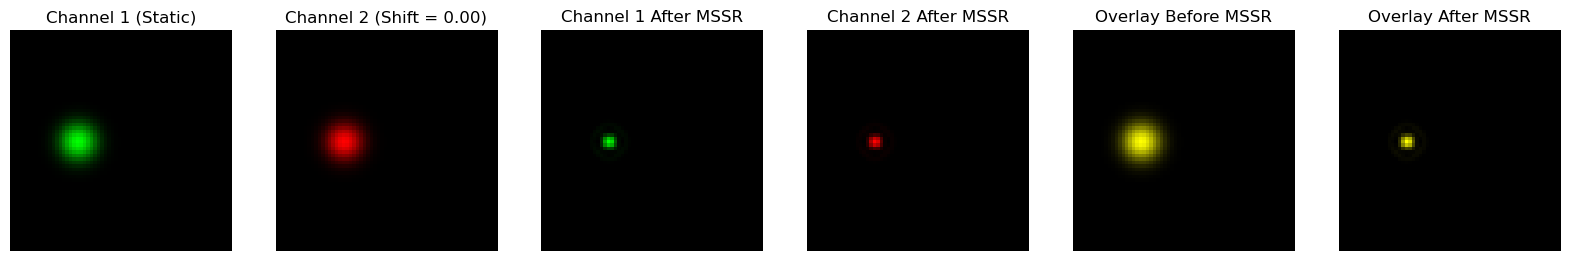

Shift: 89.66 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.997


progress: 100%|██████████| 7/7 [00:00<00:00, 2847.18it/s]

Shift: 89.66 nm -> M1 (MSSR): 0.779, M2 (MSSR): 0.792


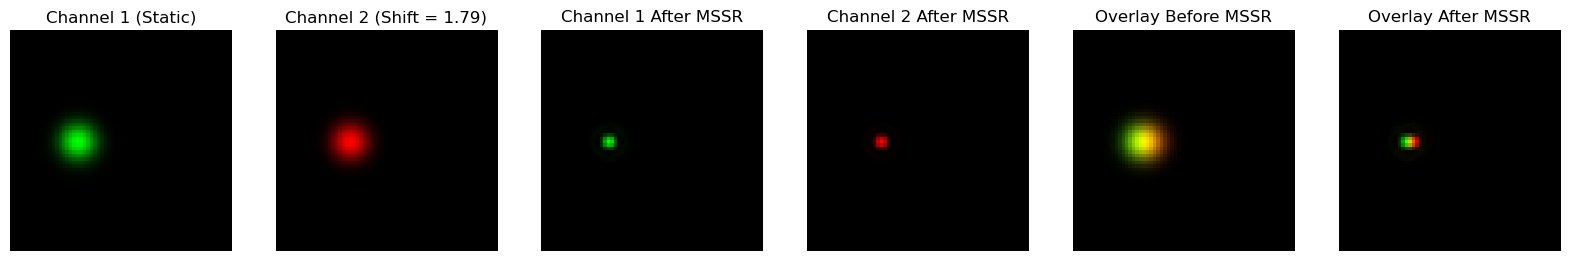

Shift: 179.32 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 7/7 [00:00<00:00, 2587.71it/s]

Shift: 179.32 nm -> M1 (MSSR): 0.615, M2 (MSSR): 0.625


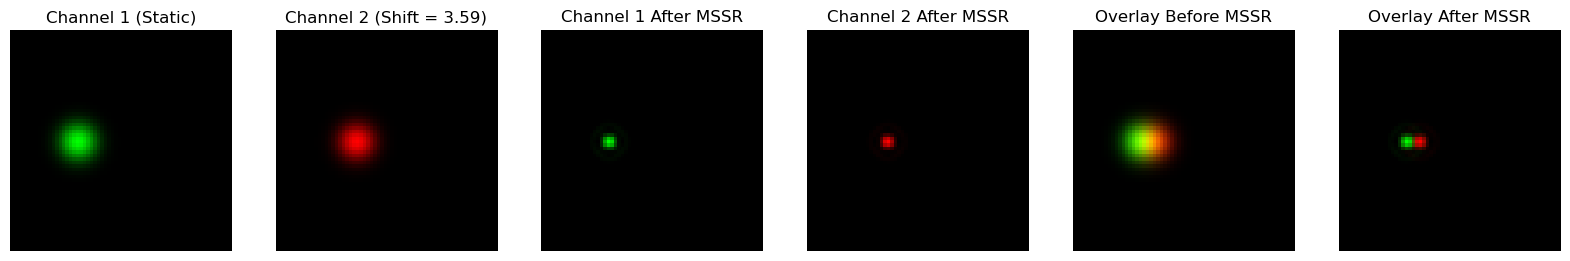

Shift: 268.99 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 7/7 [00:00<00:00, 2371.39it/s]

Shift: 268.99 nm -> M1 (MSSR): 0.434, M2 (MSSR): 0.453


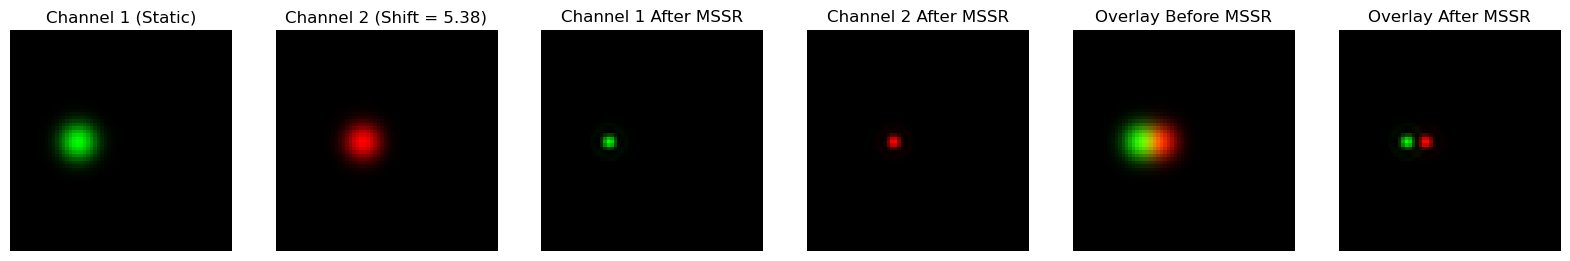

Processing Lambda2 = 500 nm
Shift: 0.00 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 9/9 [00:00<00:00, 1976.48it/s]

Shift: 0.00 nm -> M1 (MSSR): 0.992, M2 (MSSR): 0.832


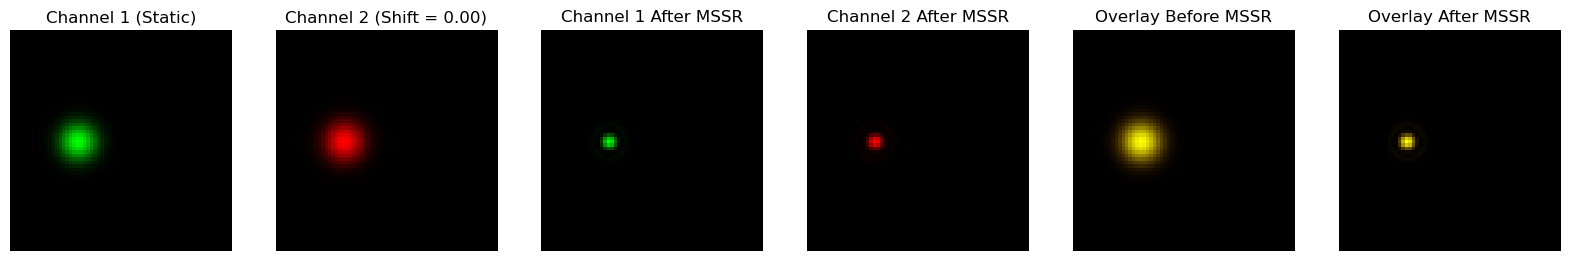

Shift: 89.66 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 9/9 [00:00<00:00, 2330.31it/s]

Shift: 89.66 nm -> M1 (MSSR): 0.892, M2 (MSSR): 0.743


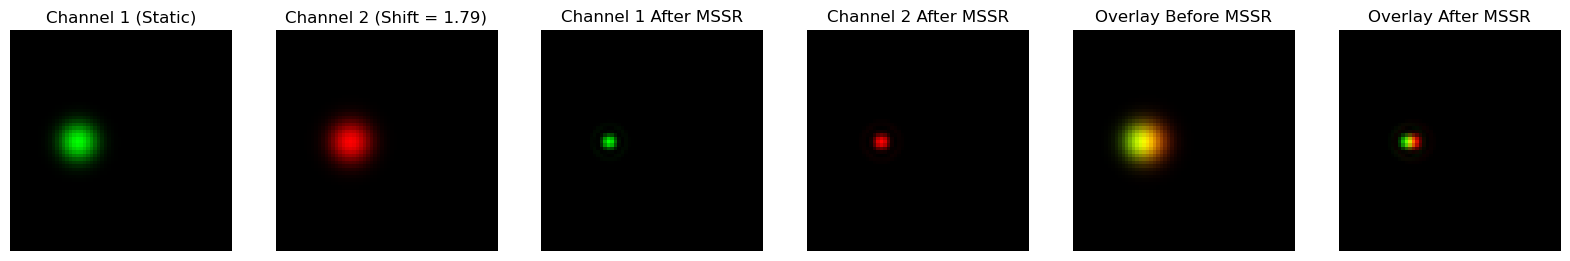

Shift: 179.32 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 9/9 [00:00<00:00, 2078.56it/s]

Shift: 179.32 nm -> M1 (MSSR): 0.7, M2 (MSSR): 0.587


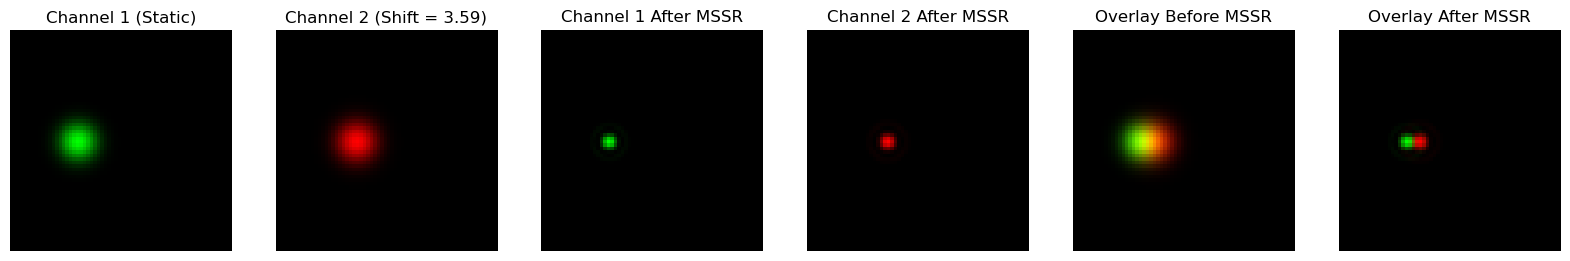

Shift: 268.99 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 9/9 [00:00<00:00, 2258.92it/s]

Shift: 268.99 nm -> M1 (MSSR): 0.508, M2 (MSSR): 0.436


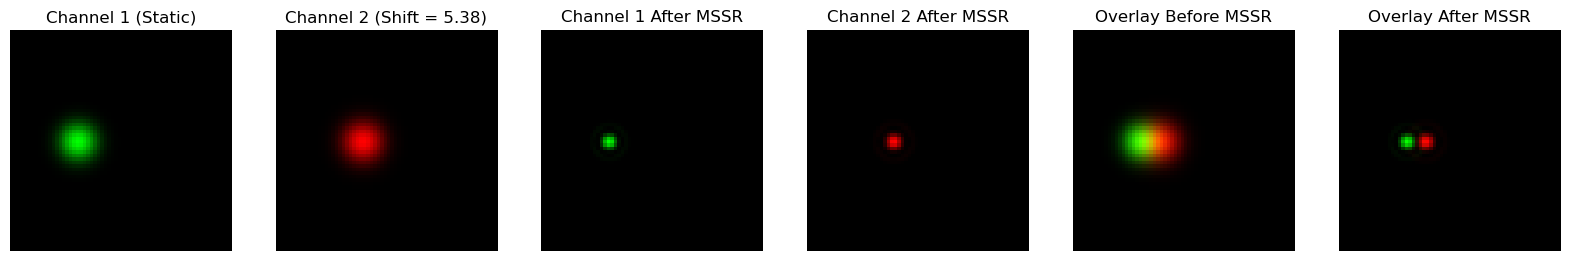

Processing Lambda2 = 550 nm
Shift: 0.00 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 9/9 [00:00<00:00, 2330.31it/s]

Shift: 0.00 nm -> M1 (MSSR): 0.992, M2 (MSSR): 0.676


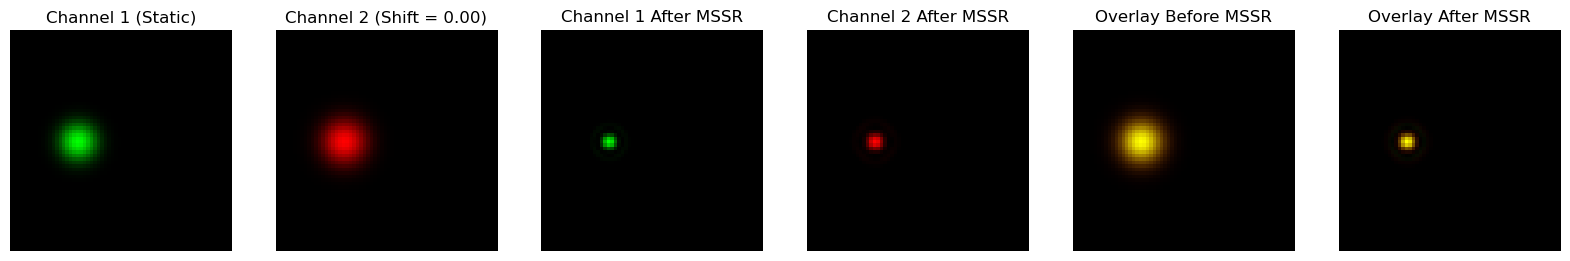

Shift: 89.66 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 9/9 [00:00<00:00, 1971.01it/s]

Shift: 89.66 nm -> M1 (MSSR): 0.967, M2 (MSSR): 0.659


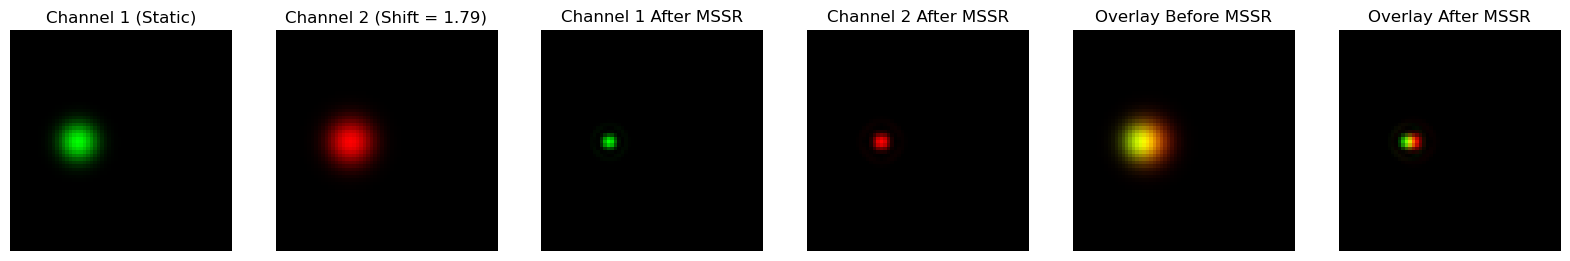

Shift: 179.32 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 9/9 [00:00<00:00, 2277.31it/s]

Shift: 179.32 nm -> M1 (MSSR): 0.792, M2 (MSSR): 0.54


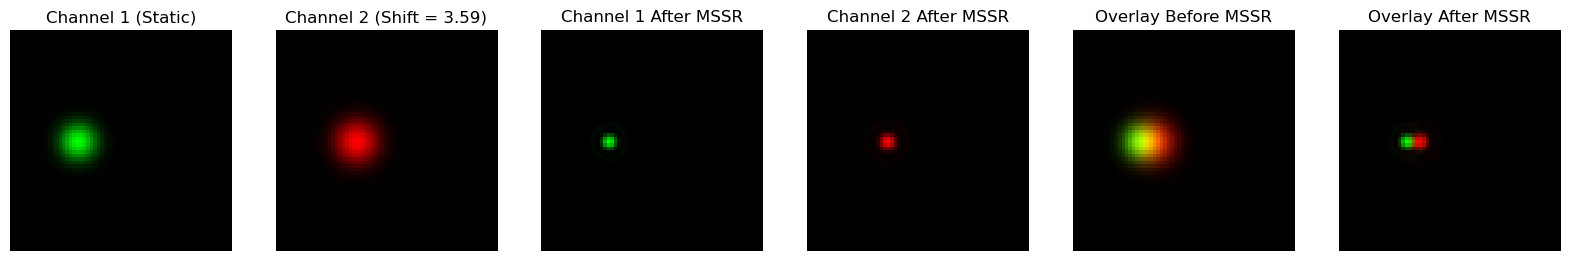

Shift: 268.99 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 9/9 [00:00<00:00, 2148.84it/s]

Shift: 268.99 nm -> M1 (MSSR): 0.583, M2 (MSSR): 0.405


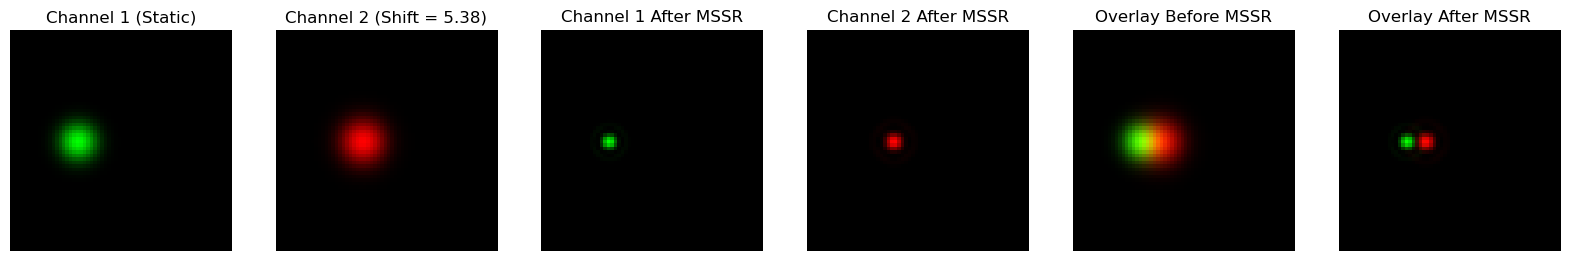

Processing Lambda2 = 600 nm
Shift: 0.00 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 11/11 [00:00<00:00, 1879.02it/s]

Shift: 0.00 nm -> M1 (MSSR): 0.992, M2 (MSSR): 0.576


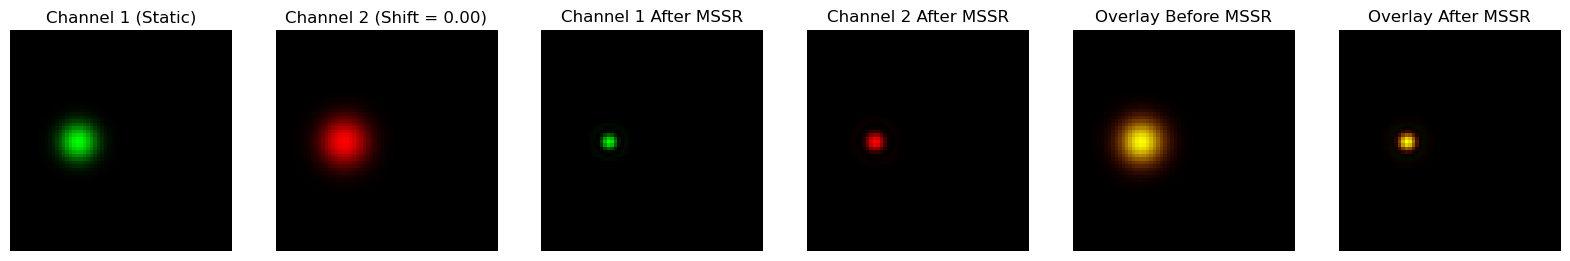

Shift: 89.66 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 11/11 [00:00<00:00, 1940.50it/s]

Shift: 89.66 nm -> M1 (MSSR): 0.992, M2 (MSSR): 0.571


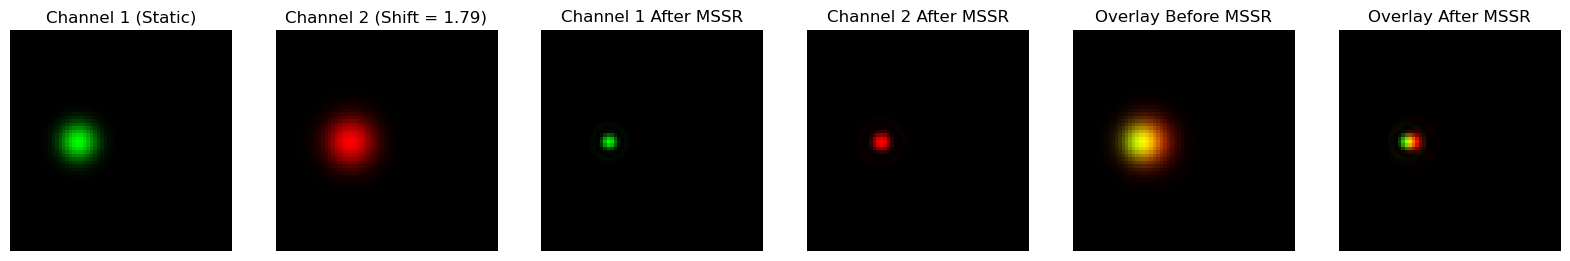

Shift: 179.32 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 11/11 [00:00<00:00, 1750.68it/s]

Shift: 179.32 nm -> M1 (MSSR): 0.877, M2 (MSSR): 0.51


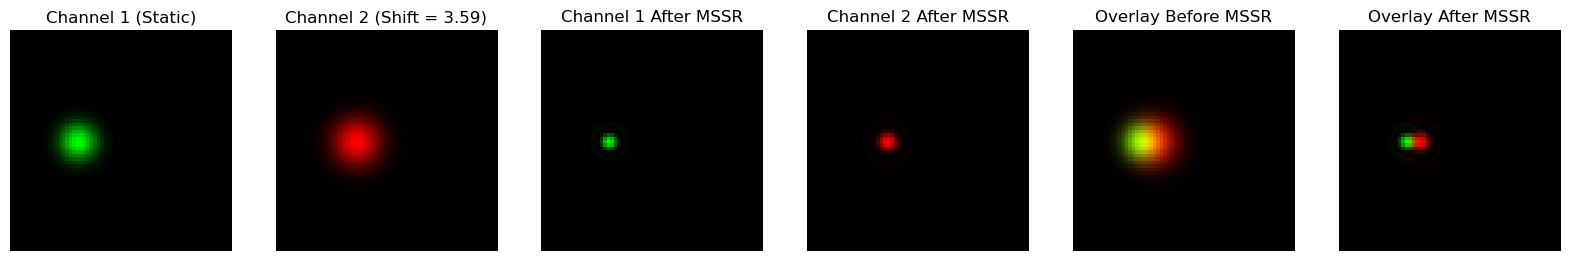

Shift: 268.99 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 11/11 [00:00<00:00, 648.98it/s]

Shift: 268.99 nm -> M1 (MSSR): 0.68, M2 (MSSR): 0.401


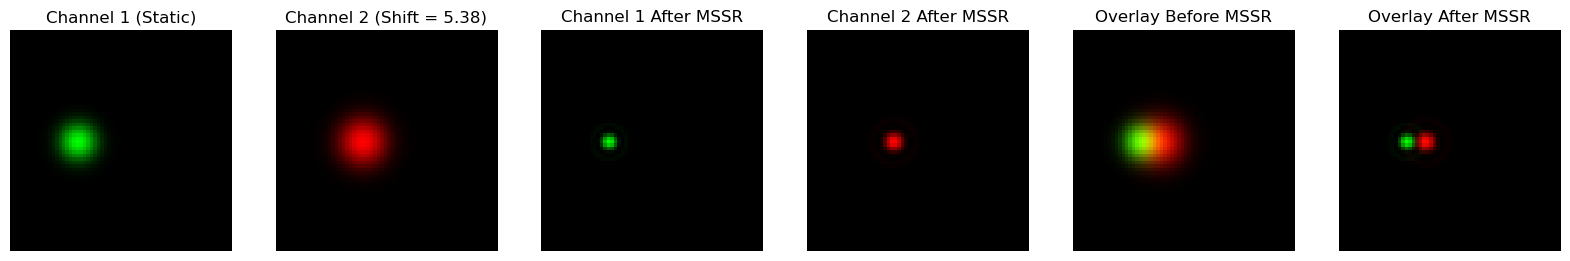

Processing Lambda2 = 650 nm
Shift: 0.00 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 11/11 [00:00<00:00, 1987.31it/s]

Shift: 0.00 nm -> M1 (MSSR): 0.992, M2 (MSSR): 0.506


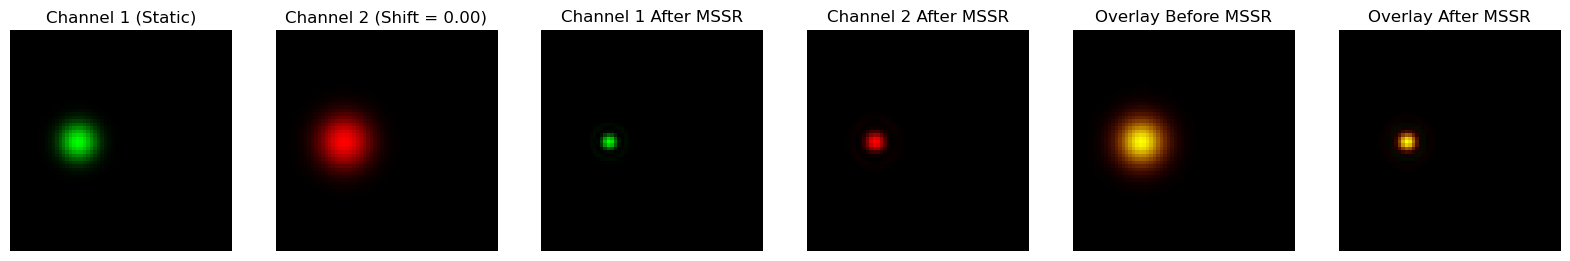

Shift: 89.66 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 11/11 [00:00<00:00, 1953.98it/s]

Shift: 89.66 nm -> M1 (MSSR): 1.0, M2 (MSSR): 0.508


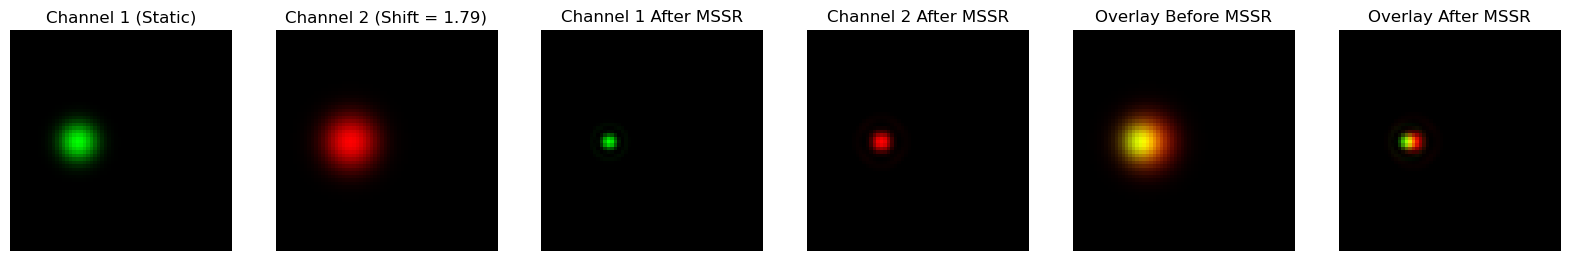

Shift: 179.32 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 11/11 [00:00<00:00, 1866.77it/s]

Shift: 179.32 nm -> M1 (MSSR): 0.959, M2 (MSSR): 0.49


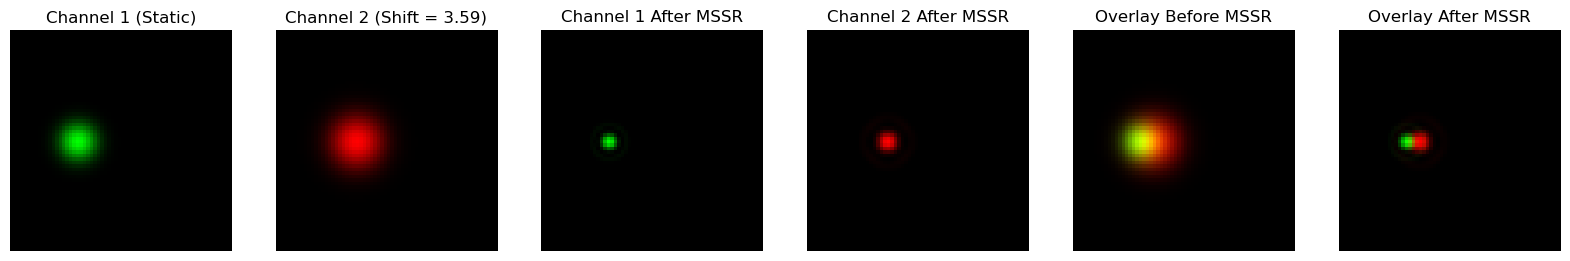

Shift: 268.99 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 11/11 [00:00<00:00, 1899.05it/s]

Shift: 268.99 nm -> M1 (MSSR): 0.779, M2 (MSSR): 0.394


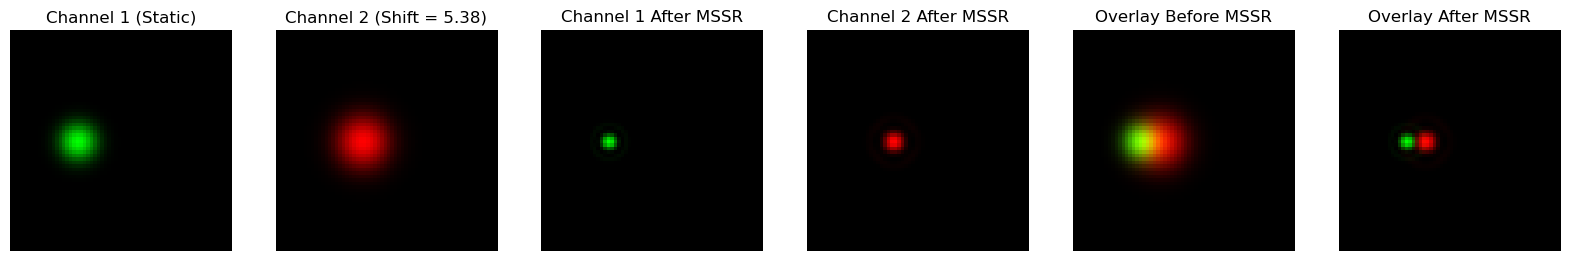

Processing Lambda2 = 700 nm
Shift: 0.00 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 11/11 [00:00<00:00, 1932.29it/s]

Shift: 0.00 nm -> M1 (MSSR): 0.992, M2 (MSSR): 0.432


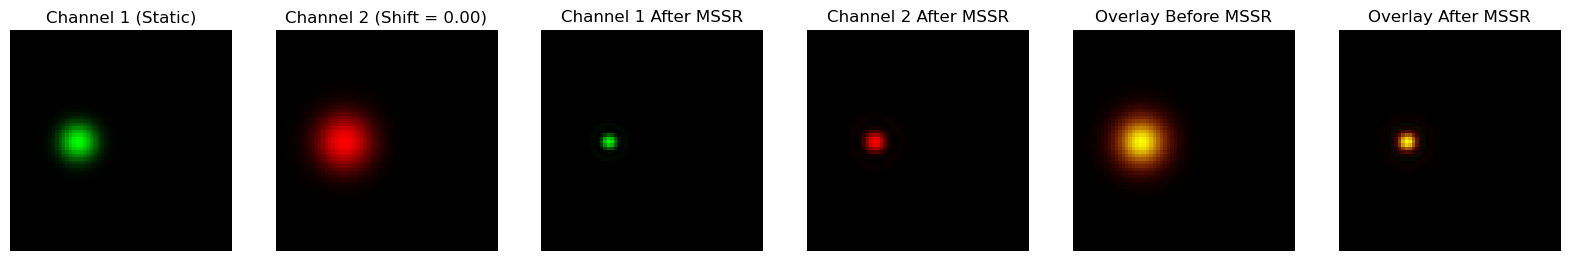

Shift: 89.66 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 11/11 [00:00<00:00, 1819.51it/s]

Shift: 89.66 nm -> M1 (MSSR): 1.0, M2 (MSSR): 0.43


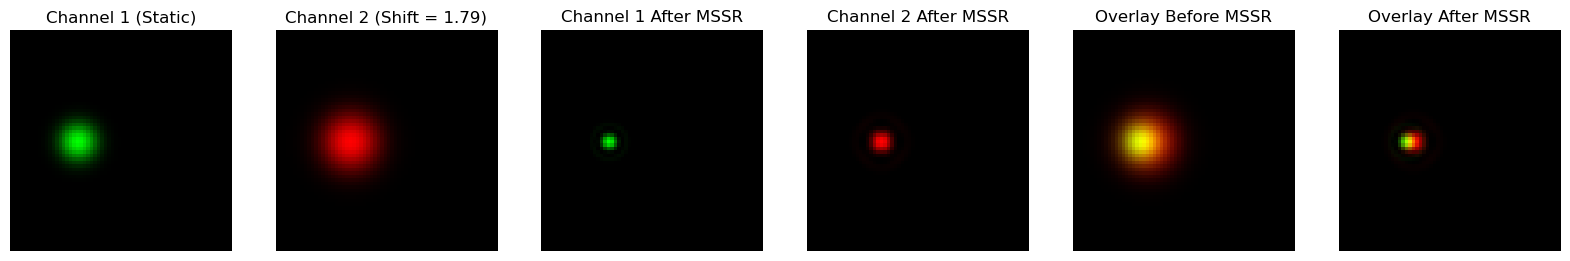

Shift: 179.32 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 11/11 [00:00<00:00, 1891.42it/s]

Shift: 179.32 nm -> M1 (MSSR): 0.992, M2 (MSSR): 0.432


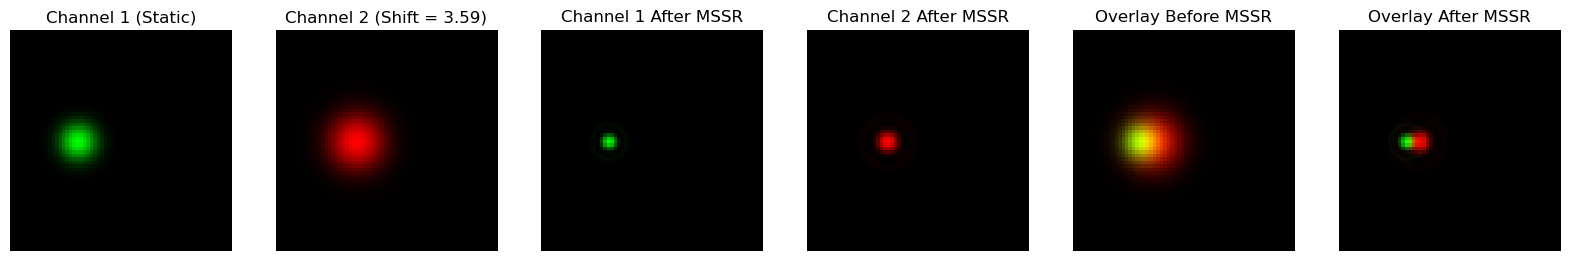

Shift: 268.99 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 11/11 [00:00<00:00, 1927.53it/s]

Shift: 268.99 nm -> M1 (MSSR): 0.836, M2 (MSSR): 0.366


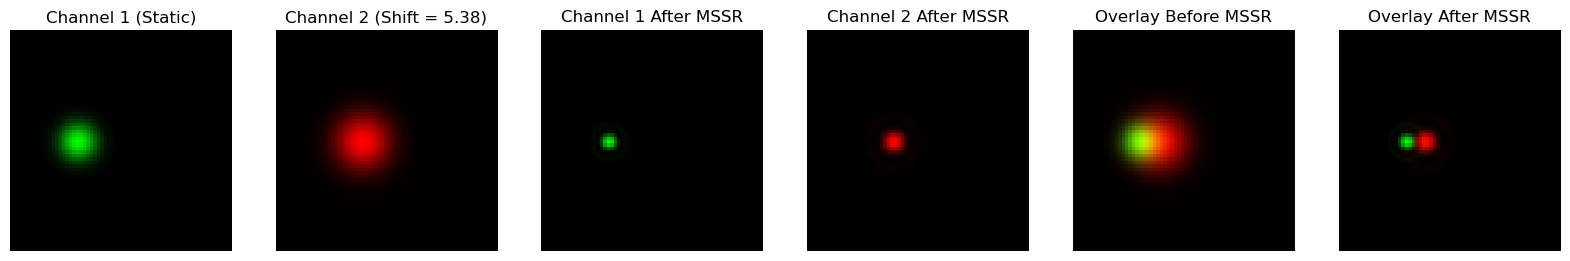

Processing Lambda2 = 750 nm
Shift: 0.00 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 13/13 [00:00<00:00, 1433.65it/s]

Shift: 0.00 nm -> M1 (MSSR): 0.992, M2 (MSSR): 0.398


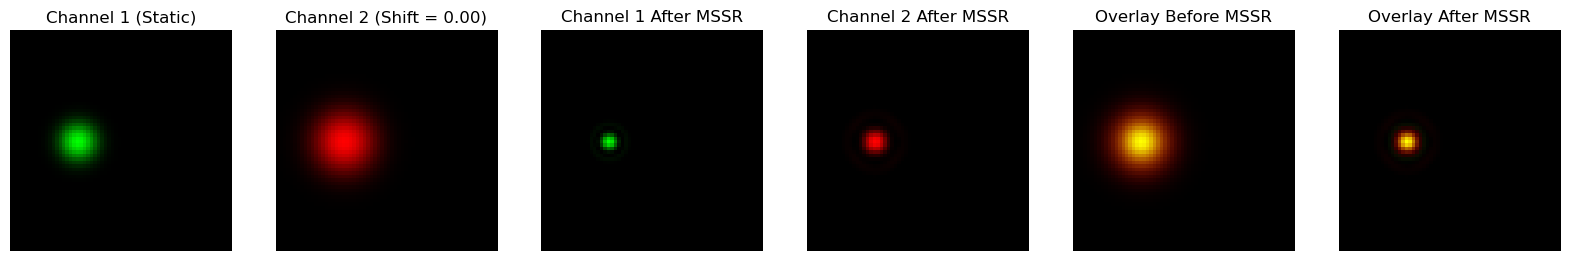

Shift: 89.66 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 13/13 [00:00<00:00, 1579.96it/s]

Shift: 89.66 nm -> M1 (MSSR): 0.992, M2 (MSSR): 0.386


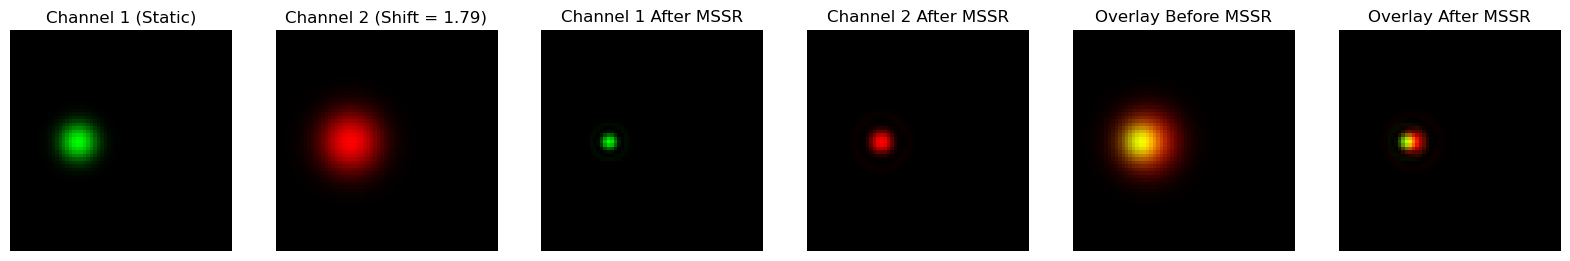

Shift: 179.32 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 13/13 [00:00<00:00, 786.22it/s]

Shift: 179.32 nm -> M1 (MSSR): 0.992, M2 (MSSR): 0.4


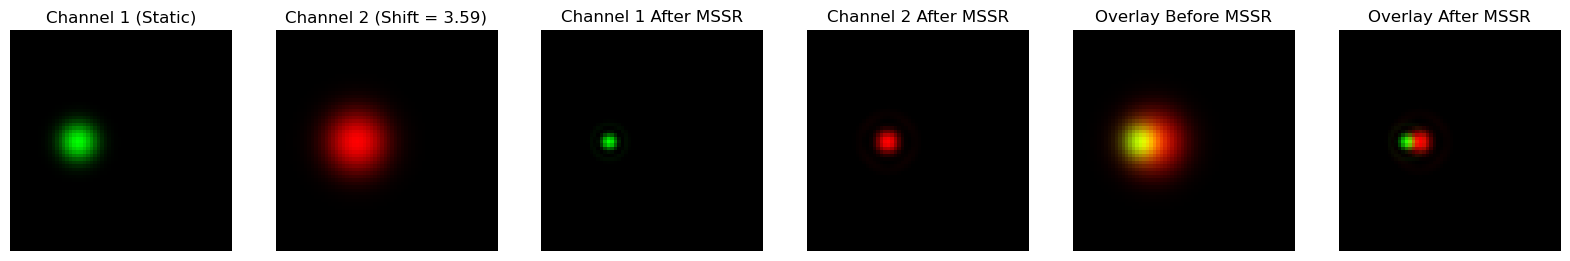

Shift: 268.99 nm -> M1 (Diffraction): 1.0, M2 (Diffraction): 0.996


progress: 100%|██████████| 13/13 [00:00<00:00, 1625.46it/s]

Shift: 268.99 nm -> M1 (MSSR): 0.907, M2 (MSSR): 0.362


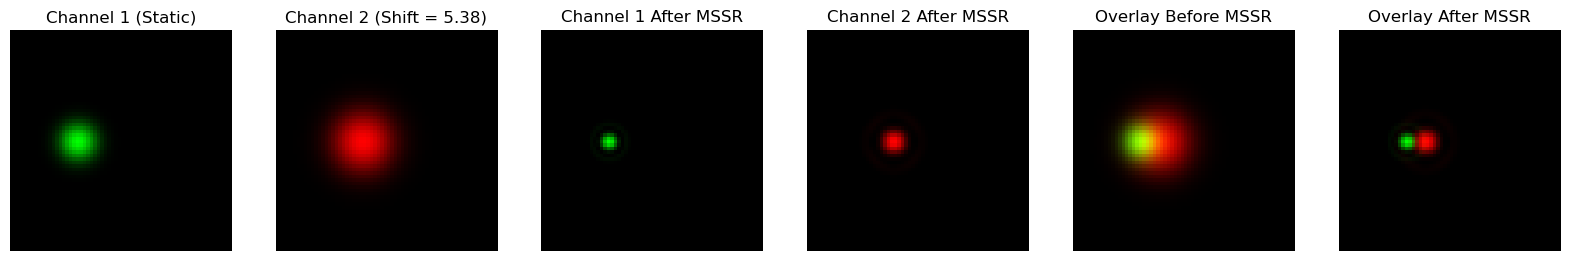

Results stored for the following Lambda2 values (nm):
- Lambda2 = 450 nm
- Lambda2 = 500 nm
- Lambda2 = 550 nm
- Lambda2 = 600 nm
- Lambda2 = 650 nm
- Lambda2 = 700 nm
- Lambda2 = 750 nm


In [13]:
# Initialize a dictionary to store the results
lambda_dict = {}

# Iterate over each lambda2 value
for l2 in lambda2_nm:
    print(f"Processing Lambda2 = {l2} nm")

    # Calculate FWHM for green and red fluorescence in pixels
    fwhm2 = calculate_physical_fwhm(l2, pixel_size_um, na)

    # Convert FWHM to sigma
    sigma2 = fwhm2 / 2.355  # Sigma for red fluorescence

    ###  Steps to separate the Gaussians
    steps = np.arange(0, 2 * sigma1, 0.5 * sigma1)

    # MSSR parameters
    mssr_fwhm = fwhm2 / 1.22  # Full width at half maximum for MSSR sharpening
    amp = 1  # Amplitude scaling for MSSR
    order = 1  # Order of derivative
    mesh = True  # Apply MSSR to a mesh grid
    ftI = False  # Fourier transform option (False for spatial domain)
    intNorm = False  # Intensity normalization (False to preserve raw intensity)

    # Call the function for the current lambda2 value
    manders_diffraction_results, manders_MSSR_results = process_gaussian_shifts(
        size=size, 
        sigma1=sigma1, 
        sigma2=sigma2, 
        steps=steps, 
        mssr_instance=mssr_instance, 
        mssr_fwhm=mssr_fwhm, 
        amp=amp, 
        order=order, 
        mesh=mesh, 
        ftI=ftI, 
        intNorm=intNorm, 
        M_threshold=M_threshold, 
        pixel_size_um=pixel_size_um, 
        normalize_and_visualize=normalize_and_visualize, 
        PLOT=True  # Disable plotting during iterations
    )
    
    # Save the results in the lambda dictionary
    lambda_dict[l2] = {
        "manders_diffraction_results": manders_diffraction_results,
        "manders_MSSR_results": manders_MSSR_results,
        "fwhm1": fwhm1,
        "fwhm2": fwhm2,
        "sigma1": sigma1,
        "sigma2": sigma2
    }

# Print a summary of the stored results
print("Results stored for the following Lambda2 values (nm):")
for l2 in lambda_dict.keys():
    print(f"- Lambda2 = {l2} nm")

Plot saved as PDF: /home/jovyan/LNMA/bravoa/model/05_MSSR-Manders-Wavelengths.pdf


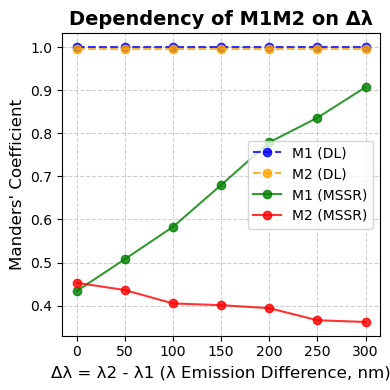

In [17]:
idx_sep = 3

import matplotlib.pyplot as plt

# Extract data for M1 and M2 at zero distance
delta_lambda_values = []  # List for delta lambda values (lambda2 - lambda1)
m1_diffraction_values = []  # List for M1 (diffraction-limited)
m2_diffraction_values = []  # List for M2 (diffraction-limited)
m1_mssr_values = []  # List for M1 (MSSR)
m2_mssr_values = []  # List for M2 (MSSR)

for l2, data in lambda_dict.items():
    delta_lambda = l2 - lambda1_nm  # Calculate delta lambda
    delta_lambda_values.append(delta_lambda)
    # Find the M1 and M2 values at zero distance (first element of results)
    m1_diffraction = data["manders_diffraction_results"][idx_sep][1]  # M1 from diffraction results
    m2_diffraction = data["manders_diffraction_results"][idx_sep][2]  # M2 from diffraction results
    m1_mssr = data["manders_MSSR_results"][idx_sep][1]  # M1 from MSSR results
    m2_mssr = data["manders_MSSR_results"][idx_sep][2]  # M2 from MSSR results
    m1_diffraction_values.append(m1_diffraction)
    m2_diffraction_values.append(m2_diffraction)
    m1_mssr_values.append(m1_mssr)
    m2_mssr_values.append(m2_mssr)

# Plot the dependency
plt.figure(figsize=(4, 4))

# Diffraction-limited M1 and M2 plots
plt.plot(
    delta_lambda_values, m1_diffraction_values, label="M1 (DL)", 
    linestyle="--", marker="o", color="blue", alpha=0.8
)
plt.plot(
    delta_lambda_values, m2_diffraction_values, label="M2 (DL)", 
    linestyle="--", marker="o", color="orange", alpha=0.8
)

# MSSR M1 and M2 plots
plt.plot(
    delta_lambda_values, m1_mssr_values, label="M1 (MSSR)", 
    linestyle="-", marker="o", color="green", alpha=0.8
)
plt.plot(
    delta_lambda_values, m2_mssr_values, label="M2 (MSSR)", 
    linestyle="-", marker="o", color="red", alpha=0.8
)

# Plot formatting
plt.title("Dependency of M1M2 on Δλ", fontsize=14, fontweight="bold")
plt.xlabel("Δλ = λ2 - λ1 (λ Emission Difference, nm)", fontsize=12)
plt.ylabel("Manders' Coefficient", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=10, loc="best")
plt.tight_layout()

# Save the plot as a PDF
plt.savefig(pdf_path, format="pdf")
print(f"Plot saved as PDF: {pdf_path}")

# Show the plot
plt.show()